In [1]:
import os, subprocess, datetime, time, sys

from astropy.io import fits
from astropy.table import Table

from numpy import log, log10, nanmedian, flipud
from numpy.random import randint, shuffle

from IPython.display import clear_output

from matplotlib import pyplot as plt


In [2]:
import numpy as np

def Normalize_LOG10(x,window=20,is_sky=False,keepColour=False):
    '''Normalize (multi-band) images uisng a logarithmic scaling while preserving colour information. 
    Input should be in linear units and be of shape (nRecords,dx,dy,nChannels).
    Input descriptions:
    
    x: input images in order (nRecords,NAXIS1,NAXIS2,N_BANDS)
    window: FULL width of the window in which the upper percentile stats are computed. The 99th percentile in this window sets the upper clipping limit.
    is_sky: is the sky level non-zero in the image (should then be True)? Or is it already subtracted (False, default).
    keepColour: Treat every band as separate data (in terms of normalization) and largely eliminate colour sensitivity (False)? Or normalize all bands by the same normalization factor (True, default)?
    '''
    x = np.log10(x)
    # get rid of pesky nan values
    x[x<-5]=np.nan
    return x

test_filename = "images_i/54047235_Cutout-525x525_i.fits"

HDUList = fits.open(test_filename)


HDUList.close()

In [5]:
def check_for_classification_table(filename="merging_classifications.fits"):
    if filename in os.listdir():
        print("Classification table found.")
    else:
        print("Classification table not found. Generate new table.")
        # Generate the properly formatted table here
        pass
    
def end_workflow(input):
    if int(input) == 9:
        return True
    else:
        return False


def question(prompt=""):
    answer = int(input(prompt))
    if answer in (0, 1):
        return answer
    elif answer == 9:
        sys.exit(0)
    
    
def workflow(img_directory = "i_band_sample/", filtered_image_directory = "i_band_filtered/",
            class_filename="Classifications.fits"):
    """ Full enclosed workflow for galaxy classification. """
    
    if class_filename in os.listdir():
        print("Classification file found in local directory.")
        t = Table.read(class_filename, format="fits")
    else:
        print("Classification file not found. Generating a new one.")
        t = Table(names=("image", "image_loc", "band", "classifier", "m_feat", "m_act", "double_n", "assym",
                        "shell", "stream", "clean", "date"), dtype=("U80", "U60", "U4", "U100", "i4", "i4", 
                                                                    "i4", "i4", "i4", "i4", "i4", "U100"))
    
    classified_images = t["image"]
    print(classified_images)
    
    
    date_and_time = str(datetime.datetime.now())
    
    classifier_name = str(input("Please enter your name: "))
    
    active_band, bands = "", ("g", "r", "i", "z", "y")
#     while active_band not in bands:
#         active_band = str(input("Please enter the band you want to work with: ")).lower()
    
    print()
    print(classifier_name, "\t Active Band =", active_band, "\t Time =", date_and_time)
    check_for_classification_table()

    clear_output()
    
    # img_directory = "images_" + active_band + "/"
    images, images_unclassified = os.listdir(img_directory), []
    images_filtered = os.listdir(filtered_image_directory)
    
    # Get all images that haven't been classified yet but also exist in the filtered image directory
    for n in images:
        if img_directory + n not in classified_images and n in images_filtered:
            images_unclassified.append(n)
    
    images = images_unclassified
    shuffle(images)
    print(len(images))

    current_selection, number_completed = 0, 0
    index = 0
    while not end_workflow(current_selection):
        print("Welcome to object classification. Remember you can always type 9 to save and exit.")
        print("For these questions, type either 1 for yes, or 0 for no.")
        print("Number of classifications done in this session: ", number_completed, "\n")
        
        
        date_and_time = str(datetime.datetime.now())
        
        # Load in a given image
        active_image = img_directory + images[index]
        local_image = images[index]
        filtered_image = filtered_image_directory + images[index]
        print("Loading:", active_image)

        # Display image
        HDUList = fits.open(active_image)
        img_data = HDUList[1].data
        
        HDUList_filtered = fits.open(filtered_image)
        filtered_img_data = HDUList_filtered[0].data
        
        fig, ax = plt.subplots(1,3)
        fig.set_figheight(10)
        fig.set_figwidth(15)
        
        img_data_norm = Normalize_LOG10(img_data)
        
        cut_x = int(img_data_norm.shape[0] / 3)
        cut_y = int(img_data_norm.shape[1] / 3)
        
        ax[0].imshow(flipud(img_data_norm), cmap="Greys", vmin=-3, vmax=1.4)
        ax[1].imshow(flipud(img_data_norm[cut_x: img_data_norm.shape[0] - cut_x , 
                                        cut_y: img_data_norm.shape[1] - cut_y]), 
                     cmap="Greys", vmin=-3, vmax=1.4)
        ax[2].imshow(filtered_img_data, cmap="Greys")
        
        ax[0].set_xticks([])
        ax[0].set_yticks([])
        ax[1].set_xticks([])
        ax[1].set_yticks([])
        ax[2].set_xticks([])
        ax[2].set_yticks([])

        plt.tight_layout()
        plt.show()
        
        
        HDUList.close()
        HDUList_filtered.close()

        time.sleep(0.5)

        
        # #######################################################################################
        # QUESTION LOOP #########################################################################
        # #######################################################################################
        has_features, has_double_nuclei, is_asymmetric, has_shell, has_stream = 0, 0, 0, 0, 0
        is_actively_merging, is_clean = 0, 0
        
        has_features = question("Does this galaxy have merging features? (Type 2 if unresolved image): ")
        
        if has_features == 1:
            is_actively_merging = question("Is this galaxy actively merging? : ")
            if is_actively_merging:
                has_double_nuclei = question("Does this galaxy possess a double nuclei : ")
                is_asymmetric = question("Does this galaxy have a global asymmetry? : ")
            has_shell = question("Does this galaxy have signs of a shell? : ")
            has_stream = question("Does this galaxy have signs of a stream? : ")
        elif has_features == 2:
            is_clean = 1

        if question("Save classifications? (1 for yes, 0 for no) :"):
            # ("img", "img_loc", "band", "classifier", "m_feat", "m_act", "double_n", "assym", 
            # "shell", "stream", "clean", "date")
            t.add_row([active_image, local_image, active_band, classifier_name, has_features,
                      is_actively_merging, has_double_nuclei, is_asymmetric,
                      has_shell, has_stream, is_clean, date_and_time])

        print(has_features, has_double_nuclei, is_asymmetric, has_shell, has_stream, is_actively_merging)

        # #######################################################################################
        #  END QUESTIONS ########################################################################
        # #######################################################################################

#         except ValueError:
#             print("Error  in loop. Scrapping this iteration.")
#             break
                       
            
        clear_output()
        
        print(class_filename)
        t.write(class_filename, overwrite=True)
        
        number_completed += 1
        index += 1
    
        
    # Open up ds9 with the selected image
    # subprocess.call("./ds9")

914
Welcome to object classification. Remember you can always type 9 to save and exit.
For these questions, type either 1 for yes, or 0 for no.
Number of classifications done in this session:  0 

Loading: i_missing/134236279_Cutout-525x525_i.fits


/home/harrison/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log10
  del sys.path[0]
/home/harrison/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app


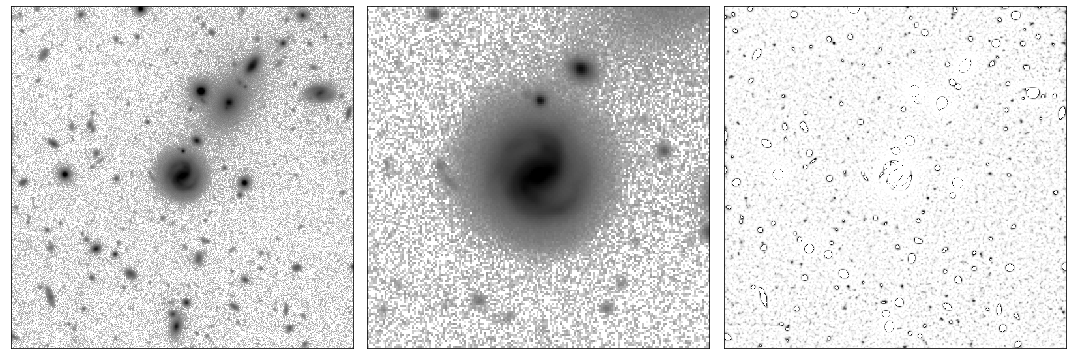

In [ ]:
# Run the workflow. Make sure all cells are run before running this one to ensure no crashing!
"""
### EXAMPLE 
Please enter your name: Harrison
Please enter the band you want t
o work with: i
Harrison     Active Band = i    Time = 2019-10-24 16:02:32.056374
Classification table found.
"""

workflow(img_directory="i_missing/", filtered_image_directory="i_missing_filtered/",
        class_filename= "Classifications_Missing.fits")